In [7]:
from init import *
from utility import *
from repro import readfile

time: 138 ms


<IPython.core.display.Javascript object>

In [2]:
class Reprobus:
    def __init__(
        self, filename, nlev=60, nbcon=44, ncm=15, islev=np.arange(350, 801, 5)
    ):
        p0, rascp = 1000.0, 2.0 / 7.0
        self.nlev = nlev
        self.filename = filename
        self.date = pd.to_datetime(filename.split("_")[2], format="%Y%m%d%H")
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1
        theta = tj1 * ((p0 / pmb) ** rascp)

        tr1 = {"Ozone": 4, "ClO": 10, "NO2": 6}
        tr2 = {
            "HNO3g": 42,
            "HNO3": 3,
            "N2O": 0,
            "POx": 10,
            "ClONO2": 13,
            "NOx": 20,
            "ClOx": 22,
            "BrOx": 23,
            "HCl": 12,
        }
        self.long_name = {
            "Ozone": "O$_3$",
            "ClO": "ClO",
            "HNO3g": "HNO$_3$ Gas",
            "HNO3": "HNO$_3$",
            "N2O": "N$_2$O",
            "NO2": "NO$_2$",
            "POx": "Passive Ox",
            "ClONO2": "ClONO$_2$",
            "NOx": "NO$_x$",
            "ClOx": "ClO$_x$",
            "BrOx": "BrO$_x$",
            "HCl": "HCl",
        }

        data = xr.Dataset()

        for k, v in tr1.items():
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)

        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)

        self.data = data

    def get_coeffs(self, cdir="."):
        cfile = "%s/ecmwf_%s_levels.txt" % (cdir, self.nlev)
        df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
        aa = 0.01 * df["a"].rolling(1).mean()[1:].values
        bb = df["b"].rolling(1).mean()[1:].values
        return aa, bb

    def isentropic_tracers(self, tmp, theta, islev, tr):
        lats = xr.DataArray(
            np.arange(90, -91, -2), dims="Latitude", attrs={"long_name": "Latitude"}
        )
        lons = xr.DataArray(
            np.arange(0, 360, 2), dims="Longitude", attrs={"long_name": "Longitude"}
        )
        levs = np.arange(nlev)  # [::-1]

        coords = [lons, lats, levs]
        dims = ["Longitude", "Latitude", "Level"]
        tattrs = {"long_name": "Temperature", "units": "K"}

        theta = xr.DataArray(theta, coords=coords, dims=dims, attrs=tattrs)
        islev = xr.DataArray(islev, dims="Theta", attrs=tattrs)
        tmp = xr.DataArray(tmp / 1e-9, dims=dims, coords=coords)
        tmp = xrvinterp(tmp, theta, islev, "Level", "Theta")
        tmp.attrs = {"long_name": "%s [ppbv]" % self.long_name[tr]}
        return tmp

time: 4.8 ms


<IPython.core.display.Javascript object>

In [3]:
def get_basemap(ax=None, min_lat=30):
    if not ax:
        fig, ax = facets(1, 1, width=10, aspect=0.6)
        ax = ax[0]
    m = Basemap(projection="spstere", lon_0=180, boundinglat=min_lat, round=True, ax=ax)
    m.drawcoastlines(linewidth=0.35)
    m.drawcountries(linewidth=0.35)
    m.drawmeridians(np.arange(0, 360, 60), labels=[0, 0, 0, 0])
    m.drawparallels(np.arange(20, 80, 20), labels=[1, 1, 0, 0])
    return m


def plot_data(molz, level=475, scale=1, min_lat=-45):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    m = get_basemap(ax=ax, min_lat=min_lat)
    data = molz.sel(Theta=level, method="nearest").T.values
    data, lon = addcyclic(data, molz["Longitude"])
    lat, lon = np.meshgrid(molz["Latitude"], lon)
    lon, lat = m(lon, lat)
    im = m.contourf(lon, lat, scale * data.T)
    cb = plt.colorbar(im, cax=cax, orientation="vertical")
    cb.set_label(label="%s" % (molz.attrs["long_name"]), size=18)
    return fig, ax, cb

time: 2.25 ms


<IPython.core.display.Javascript object>

In [4]:
nlev = 60
fname = "/media/pankaj/Data/reprobus/MODEL_history_2015050512_001410"
bus = Reprobus(fname, nlev)
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 513.1 561.8 ... 2.807e+03
    ClO        (Longitude, Latitude, Theta) float64 0.000502 ... 1.685e-06
    NO2        (Longitude, Latitude, Theta) float64 0.1356 0.1533 ... 3.062
    HNO3g      (Longitude, Latitude, Theta) float64 1.5 1.617 ... 9.634 9.403
    HNO3       (Longitude, Latitude, Theta) float64 1.793 1.942 ... 16.27 16.22
    N2O        (Longitude, Latitude, Theta) float64 304.2 301.5 ... 9.226 8.703
    POx        (Longitude, Latitude, Theta) float64 540.9 596.6 ... 6.204e+03
    ClONO2     (Longitude, Latitude, Theta) float64 0.02932 0.0341 ... 0.4344
    NOx        (Longitude, Latitude, Theta) float64 0.2105 0.2348 ... 3.064
    ClOx       (Longitude, Latitude, Theta) float64 0.0005022 ... 1.685e-06
    BrOx       (Longitude, Latitude, Theta) float64 0.001751 0.00182 ... 1e-21
    HCl        (Longitude, Latitude, Theta) float64 0.4149 0.4473 ... 2.638

time: 41.1 s


<IPython.core.display.Javascript object>

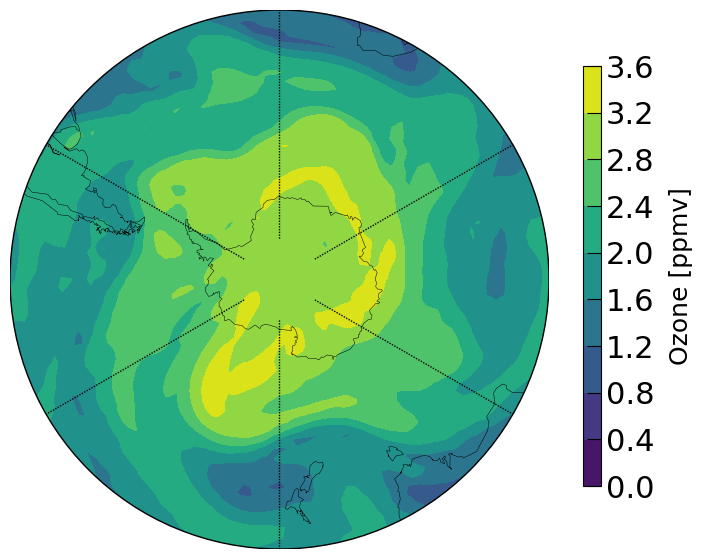

time: 417 ms


<IPython.core.display.Javascript object>

In [6]:
fig, ax, cb = plot_data(bus.data["Ozone"], level=475, scale=0.001, min_lat=-30)
cb.set_label(label="%s" % ("Ozone [ppmv]"), size=18)
# plt.savefig("/home/pankaj/Desktop/repro_ozone_435K.png", bbox_inches="tight")
plt.show()